In [1]:
# Set OPENAI_API_KEY
import os
os.environ["OPENAI_API_KEY"] = "set your api key here."

In [2]:
import re
import json
import random
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm

import itertools
import networkx as nx
import plotly.graph_objects as go
from collections import Counter

# config
seed = 0
np.random.seed(seed)

warnings.simplefilter('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option("display.max_colwidth", None)

## Read data

In [3]:
# read data
df = pd.read_csv("./dataset/primary_data.csv",)

# preprocess
df["narrative"] = df["narrative"].map(lambda x:x.lower())

# random sampling
df = df.sample(n=300, random_state=0)

In [4]:
import json
with open('./dataset/variable_mapping.json','r',encoding='utf-8') as file:
    mapping = json.load(file)
    
# convert the encoded values in the mapping to integers since they get read in as strings
for c in mapping.keys():
    mapping[c] = {int(k): v for k, v in mapping[c].items()}
    
for col in mapping.keys():
    df[col] = df[col].map(mapping[col])

## Strategy

While the "Product" column lists the items that caused falls, it doesn't explain how these items led to the falls. This gap necessitates an exploration of the underlying factors. We aim to speculate on these causative factors.

### Integration of Narrative and Tabular Information (age, sex, race, product)

The "Product" column mentions the objects involved in the incidents, but lacks details on how these objects caused falls. Without this explanation, it's challenging to devise effective strategies. Our focus under "Narrative Info" is on the question: `"Why did the fall occur?"`. These incidents often happen during `some activity`. Identifying activities unsuitable for the elderly could enable others to provide better support or inform product design. 

**Although this is a simplistic approach, gaining insights into precursor events or other relevant information from narratives is an essential step.**

Simple formula:

$$
\text{Narrative} - \text{product} - \text{injury} \cdots = \text{Insights that only narratives have?}
$$

## Morphological Analysis

In [6]:
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag

def extract_verbs(sentence):
    
    sentence = sentence.lower() # 小文字化
    tokens = word_tokenize(sentence) # 文をトークン化
    tagged_tokens = pos_tag(tokens) # トークンに品詞タグを付ける
    
    # 動詞のみを取り出す (動名詞や過去分詞形を除外)
    # verbs = [word for word, tag in tagged_tokens if tag.startswith('VB') and tag not in ['VBG', 'VBN']]
    verbs = [word for word, tag in tagged_tokens if tag.startswith('VB') or tag.startswith('VBG') or tag.startswith('VBN')]

    return verbs

verbs_morph = df["narrative"].map(extract_verbs)

In [7]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatization_word_list(word_list):
    ret=[]
    for word in word_list:
        ret.append(lemmatizer.lemmatize(word,pos="v"))
    return ret

verbs_morph2 = [lemmatization_word_list(ws) for ws in verbs_morph]

### ChatGPT

In [10]:
from langchain import PromptTemplate
from langchain import FewShotPromptTemplate
from langchain.llms import OpenAI

In [11]:
examples = [
    {
        "text": '94YOM FELL TO THE FLOOR AT THE NURSING HOME ONTO BACK OF HEAD SUSTAINED A SUBDURAL HEMATOMA',
        "verb": "FELL TO THE FLOOR"
    },
    {
        "text": '87YOF WAS GETTING UP FROM THE COUCH AND FELL TO THE FLOOR SUSTAINED ABRASIONS TO ELBOWS ADMITTED FOR HEMORRHAGIC STROKE',
        "verb": "GETTING UP FROM THE COUCH"
    },
    {
        "text": '67YOF WAS AT A FRIENDS HOUSE AND  THAT WAS ON THE FLOOR AND SUSTAINED A RIGHT RADIUS FX',
        "verb": "SLIPPED ON WATER"
    },
]

example_formatter_template = """
text: {text}
verb: {verb}\n
"""
example_prompt = PromptTemplate(
    template=example_formatter_template,
    input_variables=["text", "verb"]
)

few_shot_prompt = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    prefix="These are sentences describing situations when elderly individuals fell. Please extract from the sentences the causes of the falls and the actions the elderly individuals took when they fell.",
    suffix="text: {input}\nverb:",
    input_variables=["input"],
    example_separator="\n\n",

)
    
# ChatGPT Model
llm = OpenAI(model_name="gpt-3.5-turbo",temperature=0)

def extract_verbs_with_chatgpt(sentence):
    
    prompt_text = few_shot_prompt.format(input=sentence)
    answer = llm(prompt_text)
    print(f"TEXT: {sentence}")
    print(f"VERB: {answer}\n")
    return answer

In [9]:
verbs_chatgpt = df["narrative"].map(extract_verbs_with_chatgpt)

AuthenticationError: Incorrect API key provided: set your**********ere.. You can find your API key at https://platform.openai.com/account/api-keys.

<font size=4 color="indianred">Note: ChatGPT's performance is changing all the time. To reproduce my output, use `chatgpt_verbs_300.csv`.</font>

In [12]:
verbs_chatgpt = pd.read_csv("./output/chatgpt_verbs_300.csv",index_col=0)["narrative"]

### Comparison of Results

In [13]:
def get_word_count(words):
    df_word_freq = pd.DataFrame({"Freq":Counter(words)}).reset_index()
    df_word_freq.columns = ["Word","Freq"]
    df_word_freq = df_word_freq.sort_values("Freq",ascending=False)
    return df_word_freq

In [14]:
df_ret = pd.DataFrame()
df_ret["Narrative"] = df["narrative"]
df_ret["Morph"] = verbs_morph2
df_ret["ChatGPT"] = verbs_chatgpt.values
df_ret["ChatGPT"] = df_ret["ChatGPT"].map(lambda x:x.lower())
df_ret = pd.concat([df_ret,df],axis=1)

In [15]:
df_ret[~df_ret["ChatGPT"].str.contains("fell|fall")][["Narrative","Morph","ChatGPT"]].head(20)

,Narrative,Morph,ChatGPT
57498,78yom was leaning forward to pick up something off the floor and lost his balance and fell striking his head dx: closed head injury; laceration scalp,"[be, lean, pick, lose, fell, strike]",leaning forward to pick up something off the floor
91762,"70 yof riding lawnmower accident, went over embankment, was in yard over night found by family. dx critical polytrauma, chest trauma, closed head injury","[rid, go, be, find, dx, close]","riding lawnmower accident, went over embankment"
61136,"68yom presents after a fall from a chair at the nursing home. pt states he slid off of the chair and often does this to get pain meds. dx: chronic midline lower back pain, low level fall, l2 compression fx","[pt, slide, do, get]",slid off of the chair
395,69yowm tripped and landed on floor at home. dx right tib fracture*,"[land, dx]",tripped and landed on floor
81990,80 yom sat down on a rolling chair and was leaning over to dry off his dog when the chair slid out from under him.dx: thoracic compression fracture closed.,"[sit, be, lean, dry, slide, close]","sat down on a rolling chair, leaning over to dry off his dog"
60766,65yof was walking in a parking lot when she got her legs caught up in a discarded plastic bag and she fell onto outstretched arm dx: fractured right radius,"[be, walk, get, catch, fell, outstretched, fracture]",got her legs caught up in a discarded plastic bag
72182,73yom pt was putting on his shirt when he fell backwards hitting upper back pain floor painful dx compression fracture thoracic,"[be, put, fell, hit]",putting on his shirt
52710,"86 yof biba from home following a fall, had tripped over a flower pot, c/o pain to right side of her pelvic area, had been drinking alcohol with the family, bal - 184, dx: pubic rami fracture","[follow, have, trip, have, be, drink]",tripped over a flower pot
95673,"80yof to er w/ daughter, daughter states that 2 days ago pt had fall on stairs while climbing them , pt denies hitting head orloc, pt has right knee pain & hip pain, pt also had fall today when getting up from chair dx fall, clsd fracture of right hip","[er, pt, have, fall, climb, hit, have, have, fall, get]","climbing stairs, getting up from chair"
61629,"75 yof tripped on clothing iron cord hit head dx hematoma forehead, chi","[trip, hit]",tripped on clothing iron cord


#### Cooccurrence Network

In [16]:
# 描画する単語数の限定
def filter_word_by_frequency(texts, freq_top_n=0):
    """ 元の書く文章の出現単語リストから上位N件の単語だけを残し返す。
        N個の単語リストの各中身の要素を精査する。
    """
    # Return the original texts
    if freq_top_n <= 0:
        return texts
    
    # Count word occurrences
    c_words = Counter([word for text in texts for word in set(text)])
    
    # Get the top N words
    top_words = [word for word,cnt in c_words.most_common(freq_top_n)]
    
    # Filter the original word lists to only include the top N words
    texts_filtered = []
    for text in texts:
        filtered = list(set(top_words).intersection(set(text)))
        if len(filtered) > 0:
            texts_filtered.append(filtered)
            
    return texts_filtered

# plotly config
plotly_config = dict({
    # 'scrollZoom':'cartesian',
    'scrollZoom':True,
    'displaylogo':False,
    # 'modeBarButtonsToAdd':['drawopenpath',' drawrect','eraseshape"],
    'modeBarButtonsToRemove':["zoom","select"," lasso2d"],
})

# ノードサイズの正規化
def norm_node_sizes(vals, adjuster=100):
    """Normalize the node sizes for plotting."""
    
    v_max = max(vals)
    normalized_vals = [val / v_max * adjuster for val in vals]
    
    return normalized_vals

# エッジの計算
def calc_jaccard_coef(texts):
    """
    Args:
        texts (list): 各文章単位の単語リスト

    Returns:
        df_word_cnt (DataFrame): ジャッカード係数を含むデータフレーム
    """
    
    # 8語以上のテキストだけを保持
    # texts = [text for text in texts if len(text)>8]
    
    # 各行における2語の組み合わせを生成
    word_cmb_texts = [list(itertools.combinations(text, 2)) for text in texts]
    
    # 組み合わせの平坦化 (重複許す)
    word_cmbs = sum(word_cmb_texts, [])
    
    # 単語Aと単語Bの積集合カウント
    word_cmb_count = Counter(word_cmbs)
    
    # 単語Aと単語Bの積集合の算出
    word_A = [k[0] for k in word_cmb_count.keys()]
    word_B = [k[1] for k in word_cmb_count.keys()]
    intersection_cnt = list(word_cmb_count.values())
    
    # データフレーム化
    df_word_cnt = pd.DataFrame({
        'WORD_A': word_A, 
        'WORD_B': word_B, 
        'ITS_CNT': intersection_cnt
    })

    # 単語Aの和集合の算出
    word_A_cnt = df_word_cnt['WORD_A'].value_counts()
    df_A = word_A_cnt.reset_index()
    df_A.rename(columns={'count': 'WORD_A_CNT'}, inplace=True)

    # 単語Bの和集合の算出
    word_B_cnt = df_word_cnt['WORD_B'].value_counts()
    df_B = word_B_cnt.reset_index()
    df_B.rename(columns={'count': 'WORD_B_CNT'}, inplace=True)

    # 左外部結合
    df_word_cnt = pd.merge(df_word_cnt, df_A, how='left', on='WORD_A')
    df_word_cnt = pd.merge(df_word_cnt, df_B, how='left', on='WORD_B')

    # 同じ単語間の共起は除外
    df_word_cnt = df_word_cnt[df_word_cnt["WORD_A"] != df_word_cnt["WORD_B"]]

    # 単語A、単語Bの和集合カウント
    df_word_cnt['UNION_CNT'] = df_word_cnt['WORD_A_CNT'] + df_word_cnt['WORD_B_CNT'] - df_word_cnt['ITS_CNT']

    # Jaccard係数の算出
    df_word_cnt['JACCARD'] = df_word_cnt['ITS_CNT'] / df_word_cnt['UNION_CNT']

    return df_word_cnt

# ネットワークの構築
def build_interactive_network(G, pos, node_sizes, node_colors):
      
    # edgeデータの作成
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
    
    # edgeデータの描画
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5,color='#888'),
        # hoverinfo='none',
        opacity=1,
        mode='lines')
  
    # nodeデータの作成
    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
    
    # ホバー時の表示テキスト作成
    hover_texts = [f"{word}:{val}" for word,val in zip(list(G.nodes()),node_sizes)]
  
    # nodeの色、サイズ、マウスオーバーしたときに表示するテキストの設定
    node_trace = go.Scatter(
        x=node_x,
        y=node_y,
        text=list(G.nodes()),
        hovertext=hover_texts,#node_sizes,
        textposition='top center',
        mode='markers+text',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='Portland',
            reversescale=False,
            color=node_colors,
            size=norm_node_sizes(node_sizes), # size=node_sizes,
            colorbar=dict(
                thickness=16,
                title='Word Appearance',
            ),
            line_width=2))
     
    data = [edge_trace, node_trace]
 
    # レイアウトの設定
    layout=go.Layout(
                paper_bgcolor='rgba(0,0,0,0)',
                plot_bgcolor='rgba(0,0,0,0)',
                showlegend=False,
                hovermode='closest',
                # margin=dict(b=10, l=5, r=5, t=10),
                margin=dict(b=10, l=5, r=5, t=0),
                font=dict(size=14),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis = dict(showgrid = False, zeroline = False, showticklabels = False))
 
    fig = go.Figure(data=data, layout=layout)
    fig.update_layout(
        xaxis_title=None,
        # title=dict(text=f"頻出単語を表示",font=dict(size=30)), 
        dragmode='pan',
        margin=dict(b=0,l=0,r=0,t=20),
        # title_pad=dict(b=0,l=10,r=0,t=15),
        autosize=False, width=1000, height=500
    )
    # fig.show()
    fig.show(config=plotly_config)
    
# 共起ネットワークの描画の準備とネットワーク図の取得
def get_cooccurrence_network(texts, edge_threshold=20, freq_top_n=15):
    
    # 頻出topN単語にフィルタリング
    texts = filter_word_by_frequency(texts, freq_top_n=freq_top_n)
    # 単語リストの結合
    words_list = sum(texts,[])
    # 各単語の出現回数
    word_count = Counter(words_list)

    # 共起カウントとJaccard係数を算出
    df_graph = calc_jaccard_coef(texts)

    # 重みの分布を確認
    # df_graph ["ITS_CNT"].describe()

    # 単語ペア配列を取得
    word_pairs = df_graph[["WORD_A","WORD_B"]].values

    # 単語ぺア間の頻度を取得
    edge_weights = df_graph[["ITS_CNT"]].values.reshape(-1)
    # edge_weights = df_graph[[“JACCARD”]] # 精度悪いので使用しない

    # 単語ペアと重みの長さの確認
    assert len(word_pairs)==len(edge_weights)

    # ノード(単語)の作成
    # ※ 抽出された単語が一文の中に1つしかない場合の単語はここでは除去されている
    nodes = sorted(set(word_pairs.reshape(-1)))
    
    # グラフの作成
    G = nx.Graph ()
    # 接点／単語（node）の追加
    G.add_nodes_from(nodes)
    # print('Number of nodes: {}.format (G.number of nodes()))
    
    # 線（edge）の追加
    # edge_thresholdで線を結ぶか判定
    for i in range(len(word_pairs)):
        pair = word_pairs [i]
        edge_weight = edge_weights[i]
        if edge_weight >= edge_threshold:
            G.add_edge(pair[0], pair[1])
    # print('Number of edges: (}'.format(G.number_of_edges()))
    
    # ノードが存在しない場合
    if len(G.nodes())<=1:
        return None
                                    
    # 孤立したnodeを削除
    isolated = [n for n in G.nodes if len([i for i in nx.all_neighbors(G,n)]) == 0]
    for n in isolated:
        G.remove_node(n)
    # print('Number of nodes: {}'.format(G.number_of_nodes()))

    # 単語出現数でnodeサイズを変更する
    # for n in G.nodes():
    #     print(n)
    word_size_dic = {node:word_count[node] for node in G.nodes()}

    # 名文章で出てくる割合
    # 既に単語は1文1カウントになっている
    n_data = len(texts)
    word_freq_dic = {key:val/n_data for key, val in word_size_dic.items()}
    
    # グラフレイアウト
    pos = nx.spring_layout(G,k=None) # k = node間反発係数
    
    # nodeの色をページランクアルゴリズムによる重要度により変える
    # pr = nx_pagerank(G)
    
    # print(word_size_dic)
    
    # インタラクティブな共起ネットワークの可視化
    fig = build_interactive_network (G, pos, list(word_size_dic.values()), list(word_freq_dic.values()))
    # fig = build_Cooccurrence_network(G, pos, list(word_size_dic.values()), list(pr.values()))
    return fig

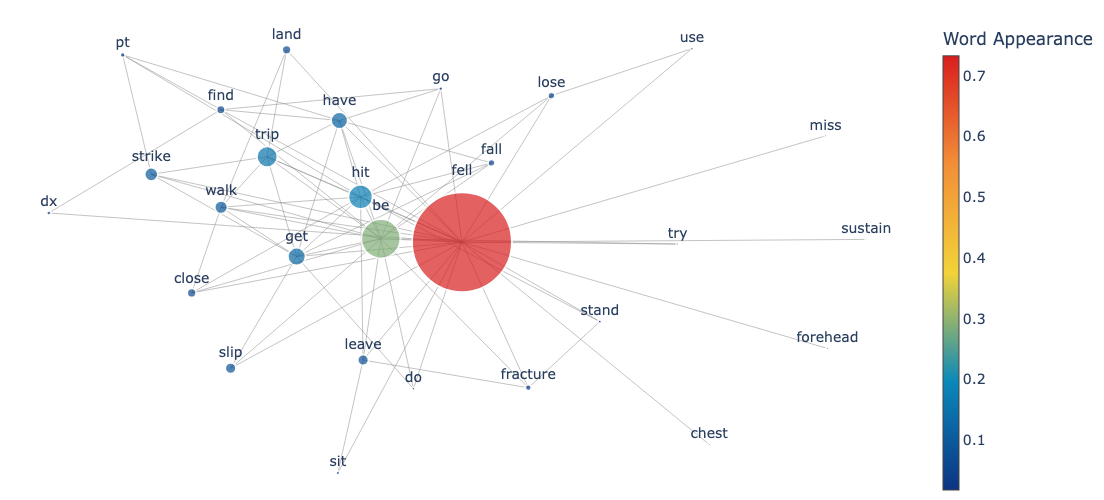

In [18]:
# Get each word list of narratives
lines = df_ret['Morph'].values
get_cooccurrence_network(lines, edge_threshold=3, freq_top_n=30)

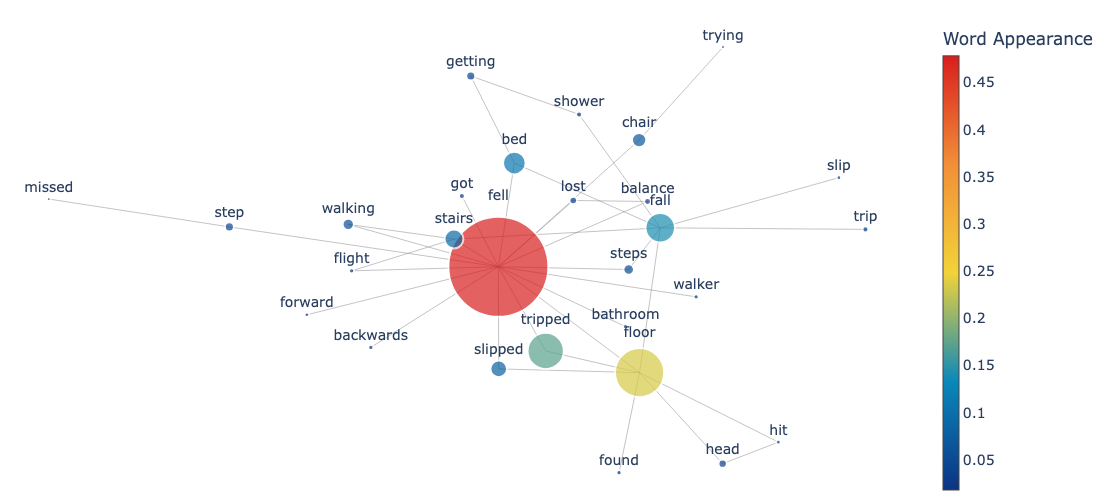

In [19]:
from nltk.corpus import stopwords
# Get each word list of narratives
# Remove unnecessary words from narrative
remove_pos_tag_list = ['CC', 'JJ', ',', '.', ')', '(', 'IN']
stop_words = stopwords.words('english')
stop_words += ["sustained","was","fx","wa"]

def remove_words_from_narrative(s):
    s = s.lower()
    ws = nltk.word_tokenize(s)
    ws = [w for w in ws if w.isalpha()]
    pos = nltk.pos_tag(ws)
    ws = [p[0] for p in pos if (not p[1] in remove_pos_tag_list)&(not p[0] in stop_words)]
    return ws

# lines = df_ret['ChatGPT'].map(word_tokenize)
df_ret['ChatGPT_refined'] = df_ret['ChatGPT'].map(remove_words_from_narrative)
lines = df_ret['ChatGPT_refined'].values
get_cooccurrence_network(lines, edge_threshold=3, freq_top_n=30)

### Differences in antecedent events among demographic groups

In [20]:
df_ret["age_c"] = df_ret["age"].map(lambda x:x//5 *5)

In [21]:
category_col='age_c' #'race'#'age_c','sex'

# 空の辞書を作成して、カテゴリごとに単語の頻出リストを格納
word_freq = {}
for category in sorted(df_ret[category_col].unique()):
    # そのカテゴリのすべての単語を1つのリストに結合
    words_in_category = df_ret[df_ret[category_col] == category]['ChatGPT_refined'].sum()
    # 単語の出現回数をカウント
    word_count = pd.Series(words_in_category).value_counts().to_dict()
    word_freq[category] = word_count
    
pd.DataFrame(word_freq).head(20)

,65,70,75,80,85,90,95,100
fell,18.0,16.0,26.0,30.0,23.0,13.0,7.0,1.0
floor,9.0,8.0,11.0,17.0,8.0,3.0,8.0,1.0
tripped,6.0,11.0,14.0,6.0,7.0,1.0,3.0,NaN
stairs,6.0,1.0,6.0,8.0,1.0,3.0,NaN,NaN
lost,4.0,1.0,NaN,3.0,1.0,1.0,NaN,NaN
balance,4.0,1.0,NaN,2.0,1.0,1.0,NaN,NaN
slipped,3.0,6.0,5.0,3.0,3.0,1.0,NaN,1.0
steps,3.0,3.0,3.0,2.0,2.0,1.0,NaN,NaN
chair,3.0,1.0,3.0,7.0,6.0,NaN,NaN,NaN
get,3.0,3.0,NaN,2.0,NaN,NaN,NaN,NaN


In [22]:
df_ret["age_c"].value_counts().sort_index()
# 186/114

age_c
65     39
70     47
75     57
80     64
85     56
90     24
95     11
100     2
Name: count, dtype: int64